## Test of the Stability Constrained ADRK



In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
from scipy.integrate import odeint
from dynamical_models import Lorenz_63, Lorenz_96, oregonator, Adv_Dif_1D
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from utils import RMSE
from tqdm import tqdm
import sympy as sp

In [2]:
# generating training data
class GD:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -4
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 10.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train = np.reshape(catalog.true_solution[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Grad_t  = np.reshape(np.gradient(catalog.true_solution[:-10-1,0])/GD.dt_integration,(X_train.shape))
Y_train = np.reshape(catalog.true_solution[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

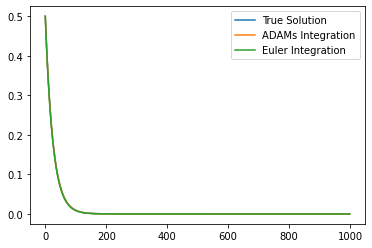

In [3]:
plt.plot(catalog.true_solution[:1000],label = 'True Solution')
plt.plot(catalog.num_integration[:1000],label = 'ADAMs Integration')
plt.plot(catalog.euler_integration[:1000],label = 'Euler Integration')
plt.legend()

In [4]:
#NN parameters 
params = {}
params['lin_coef']= GD.parameters.w
params['dim_input']=1
params['dim_output']=1
params['dim_observations']=1
params['dt_integration']=GD.dt_integration
params['ntrain']=[100,0,10000]
params['order'] = 7
pretrained = False
path = None#'Lin_w=-05.pt'
order= 7#number of stages of the runge kutta scheme

In [5]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =params['lin_coef']
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model =  FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a).double())
            self.b = torch.nn.Parameter(torch.from_numpy(b).double())
            self.c = torch.nn.Parameter(torch.from_numpy(c).double())
            self.Dyn_net = model
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
modelRINN = INT_net(params)
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
            if hasattr(module, 'a'):
                module.a.data[0,:,:] = torch.tril(module.a.data[0,:,:], diagonal=-1)
                module.a.data[0,:,0] = module.c.data - module.a[0,:,1:].data.sum(axis = 1)
# Defining the integration gain class and the gain optimization loss
class Gain(torch.nn.Module):
    def __init__(self):
        super(Gain, self).__init__()
        self.Pred_net_RINN = modelRINN

    def forward(self, h_int):
        a_to=self.Pred_net_RINN.a.clone()#.detach() 
        gain = 1+h_int.unsqueeze(1)*torch.bmm(torch.bmm(self.Pred_net_RINN.b.unsqueeze(0).repeat(h_int.shape[0],1,1),torch.inverse(torch.eye(a_to.shape[1])-h_int.unsqueeze(1)*a_to)),torch.ones_like(self.Pred_net_RINN.b.T).unsqueeze(0).repeat(h_int.shape[0],1,1))

        #gain = 1+h_int*torch.bmm(torch.bmm(self.Pred_net_RINN.b.unsqueeze(0),torch.inverse(torch.eye(a_to.shape[1])-h_int*a_to)),torch.ones_like(self.Pred_net_RINN.b.T).unsqueeze(0))
      
        return gain[:,0,0]


In [6]:
x = (torch.from_numpy(X_train).double())
y = (torch.from_numpy(Y_train).double())
z = (torch.from_numpy(Grad_t).double())

modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(), lr  = 0.01)
clipper   = applyRK_Constraints()

print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp  = modelRINN(x[b,:,:],params['dt_integration'],params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred, y[b,:,:])+criterion(pred2[:-1,:], pred[1:,:])+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            modelRINN.apply(clipper)

Learning dynamical model


/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


In [7]:
model_int   = Gain()
optimizer   = torch.optim.Adam(model_int.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10000,min_lr=.00000001, verbose=True)

In [8]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100,min_lr=1E-12, verbose=True)

In [9]:
nb_batch    = 20
res = 0.1
res_init = 1.0
train_cond       = True
train_cond_glob  = True
count_div   = 1

In [10]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [ ]:
model_int.Pred_net_RINN.apply(clipper)
t = 0
const_freq = 1
train_cond_glob = True
count_in_res = 0
while train_cond_glob :
    train_cond = True
    h_init      = torch.arange(0,2*order**2+res_init,res_init).double()
    h_init[np.where(h_init>=2*order**2)] = 2*order**2 - 1E-4
    h_to_train = h_init[1:][torch.where(torch.abs(model_int(-h_init[1:].reshape(-1,1)))>0.9)[0]]
    idxs = torch.where((h_to_train[1:] - h_to_train[:-1])>res_init+0.01)
    idx_packs = np.concatenate((np.array(0).reshape(1),idxs[0][:].numpy()+1,np.array(-1).reshape(1)))
    h_to_train_listed = []
    h_to_train_listed_affined = []
    i = 0
    for i in range(idx_packs.shape[0]-2):
        h_to_train_listed.append(h_to_train[idx_packs[i]:idx_packs[i+1]])
        h_to_train_listed_affined.append(torch.arange(h_to_train_listed[-1][0],h_to_train_listed[-1][-1],res))
    h_to_train_listed.append(h_to_train[idx_packs[i]:])
    h_to_train_listed_affined.append(torch.arange(h_to_train_listed[-1][0]-res,h_to_train_listed[-1][-1],res))    
    while train_cond :
        lpb = []
        for b in range(len(h_to_train_listed_affined)):
            gain_op = model_int(-h_to_train_listed_affined[b].reshape(-1,1))
            # Compute and print loss
            loss    = torch.relu(torch.abs(gain_op)-torch.ones_like(torch.abs(gain_op))).sum()#customized_loss((gain_op), 0*gain_true)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            model_int.Pred_net_RINN.apply(clipper)
            lpb.append(loss.detach().numpy())
        for g in optimizer.param_groups:
            print(count_in_res,sum(lpb),res,g['lr'])
        #print(count_in_res,sum(lpb),res)
        scheduler.step(sum(lpb))
        if sum(lpb) == 0:
            train_cond = False
            count_in_res = count_in_res+1
            if count_in_res > 20:
                print('refining mesh')
                res_init = res_init/5
                res = res/5
                count_in_res = 0
                if 1E-4<res<0.004:
                    for g in optimizer.param_groups:
                        g['lr'] = 1E-9
                    pat = 100
                    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=pat,min_lr=.000000001, verbose=True)
                elif 1E-5<res<1E-4:
                    for g in optimizer.param_groups:
                        g['lr'] = 1E-10
                    pat = 100
                    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=pat,min_lr=1E-12,eps = 1E-16, verbose=True)
                elif res<1E-5:
                    for g in optimizer.param_groups:
                        g['lr'] = 1E-10
                    pat = 100
                    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=pat,min_lr=1E-12,eps = 1E-16, verbose=True)
                else:
                    pat = 500
                    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=pat,min_lr=.000000001, verbose=True)
    if res<1E-3:#res<1E-4:
        train_cond_glob = False

In [12]:
#extracting integration scheme params
a=modelRINN.a.clone().detach().data.numpy()[0,:,:]
b=modelRINN.b.clone().detach().data.numpy()[0,:]
c=modelRINN.c.clone().detach().data.numpy()[0,:]

x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
x2,im_w    = sp.symbols('x2 im_w',real=True)

xt   = sp.symbols('x1+ix2')
lamb = re_w+sp.I*im_w

In [13]:
rz = np.arange(-2*order**2-2,0+0.000001,0.01)
iz = np.arange(-7.5,7.5+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [14]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
gain_arg = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = 1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b))
        if np.abs(tmp)<1:
            gain_arg.append(np.angle(tmp)/np.angle(np.exp(z[i,j])))
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 1501/1501 [21:57<00:00,  1.14it/s]


Text(0, 0.5, '$Imag(h\\lambda)$')

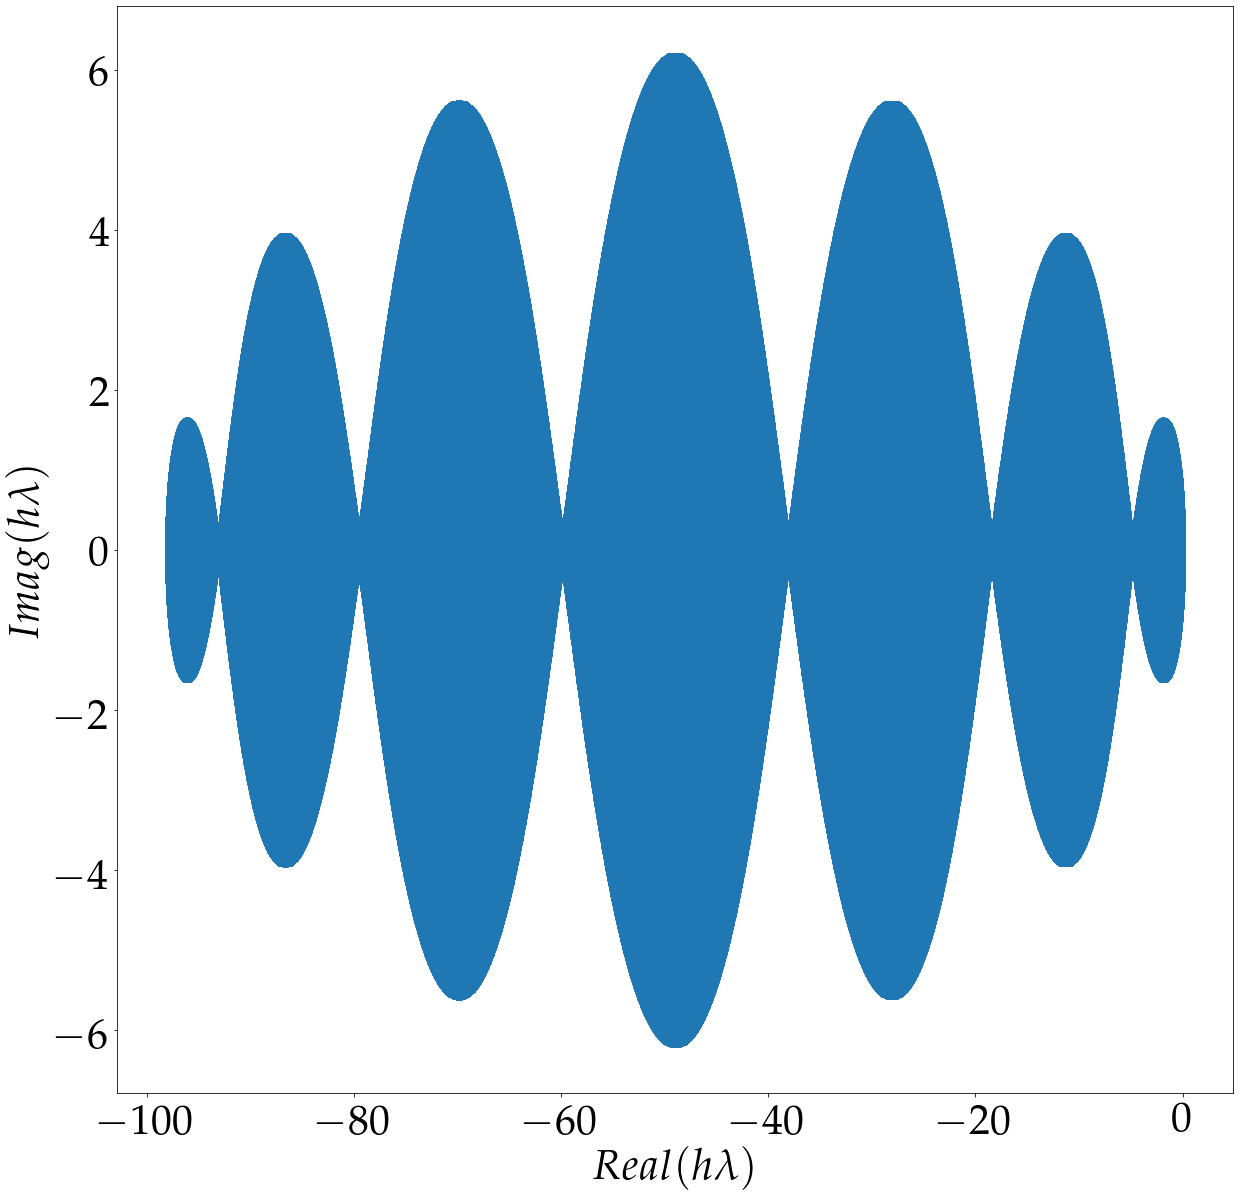

In [15]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_x),np.array(list_y))
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
#plt.xlim(-7,0)
#plt.ylim(-5,5)
